In [174]:
%matplotlib inline


# Solving Blackjack with Reinforcement Learning


<img src="file://_static/img/tutorials/blackjack_AE_loop.jpg" width="650" alt="agent-environment-diagram" class="only-light">
<img src="file://_static/img/tutorials/blackjack_AE_loop_dark.png" width="650" alt="agent-environment-diagram" class="only-dark">

In this tutorial, we’ll explore and solve the *Blackjack-v1*
environment.

**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - stand (0): the player takes no more cards
 - hit (1): the player will be given another card, however the player could get over 21 and bust

**Approach**: To solve this environment by yourself, you can pick your
favorite discrete RL algorithm. The presented solution uses *Q-learning*
(a model-free RL algorithm).




## Imports and Environment Setup




In [1]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import random
import os

import gymnasium as gym

from blackjack import ControlType, BlackJackAgent
import visualize
from visualize import reward_plot, training_plot, create_grids, create_plots, culmulative_return_calculate, reward_count, reward_compare_plot


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True)

In [38]:
Training_Culmulative_Return_ls = []
Training_reward_moving_average_ls = []
Testing_Culmulative_Return_ls = []
Testing_reward_moving_average_ls = []

.. code:: py

  # Other possible environment configurations are:

  env = gym.make('Blackjack-v1', natural=True, sab=False)
  # Whether to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

  env = gym.make('Blackjack-v1', natural=False, sab=False)
  # Whether to follow the exact rules outlined in the book by Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.




## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




In [177]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# observation = (16, 9, False)

Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)




## Executing an action

After receiving our first observation, we are only going to use the
``env.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the environment, but in the Blackjack-v1
environment you can ignore it. For example in Atari environments the
info dictionary has a ``ale.lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call ``env.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.




In [178]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).




## Building an agent

Let’s build a ``Q-learning agent`` to solve *Blackjack-v1*! We’ll need
some functions for picking an action and updating the agents action
values. To ensure that the agents explores the environment, one possible
solution is the ``epsilon-greedy`` strategy, where we pick a random
action with the percentage ``epsilon`` and the greedy action (currently
valued as the best) ``1 - epsilon``.




To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each episode. The agent will have to experience a lot of episodes to
explore the environment sufficiently.

Now we should be ready to build the training loop.




Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent.
If you want to converge to the optimal policy, try increasing
the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).




# Q-Learning

## Parameters Studies for Q-Learning Algorithm

Discount 

100%|██████████| 10000/10000 [00:01<00:00, 5061.33it/s]


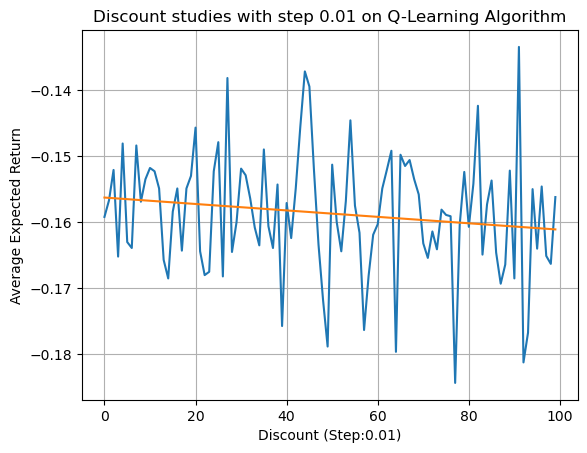

In [179]:
#Discount Hyper Paramter Studied
Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type = ControlType.Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on Q-Learning Algorithm'.format(discount_step))
plt.grid(True)
plt.show()
    

Epsilon

100%|██████████| 10000/10000 [00:02<00:00, 4878.58it/s]


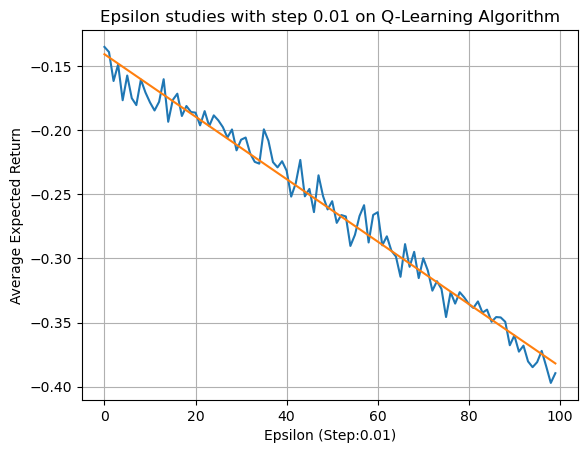

In [180]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,discount_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i
    discount = 0.01

    control_type == ControlType.Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on Q-Learning Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

Learning Rate

100%|██████████| 10000/10000 [00:02<00:00, 4897.13it/s]


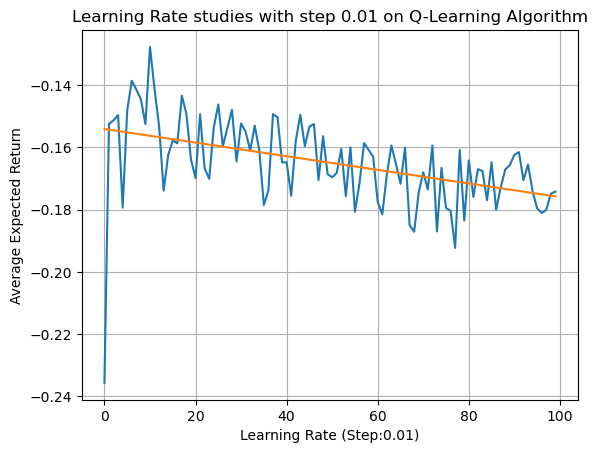

In [8]:
#Learning Rate Hyper Paramter Studied
Expected_Return_ls = []
learning_rate_step = 0.01
learning_rate_ls = np.arange(0,1,learning_rate_step)

for i in  learning_rate_ls:
    # hyperparameters
    learning_rate = i
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = 0.01

    control_type = ControlType.Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Learning Rate (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Learning Rate studies with step {} on Q-Learning Algorithm'.format(learning_rate_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [39]:
#Training Q-Learning
# hyperparameters
learning_rate = 0.01
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [02:50<00:00, 5867.93it/s]


Save Agent

In [40]:
#Save Double Q-Learning agent
q_value_file = "q_learning.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with Q-Learning Algorithm

====================== Reward Frequency ======================

Iteration[0:100000]     positive:0.29781 negative:0.65771
Iteration[100000:200000]     positive:0.32701 negative:0.61961
Iteration[200000:300000]     positive:0.35768 negative:0.58038
Iteration[300000:400000]     positive:0.38953 negative:0.53792
Iteration[400000:500000]     positive:0.41821 negative:0.50048
Iteration[500000:600000]     positive:0.4331 negative:0.47956
Iteration[600000:700000]     positive:0.43202 negative:0.48014
Iteration[700000:800000]     positive:0.43003 negative:0.47991
Iteration[800000:900000]     positive:0.4302 negative:0.48012
Iteration[900000:1000000]     positive:0.43045 negative:0.482

====================== Reward Frequency ======================


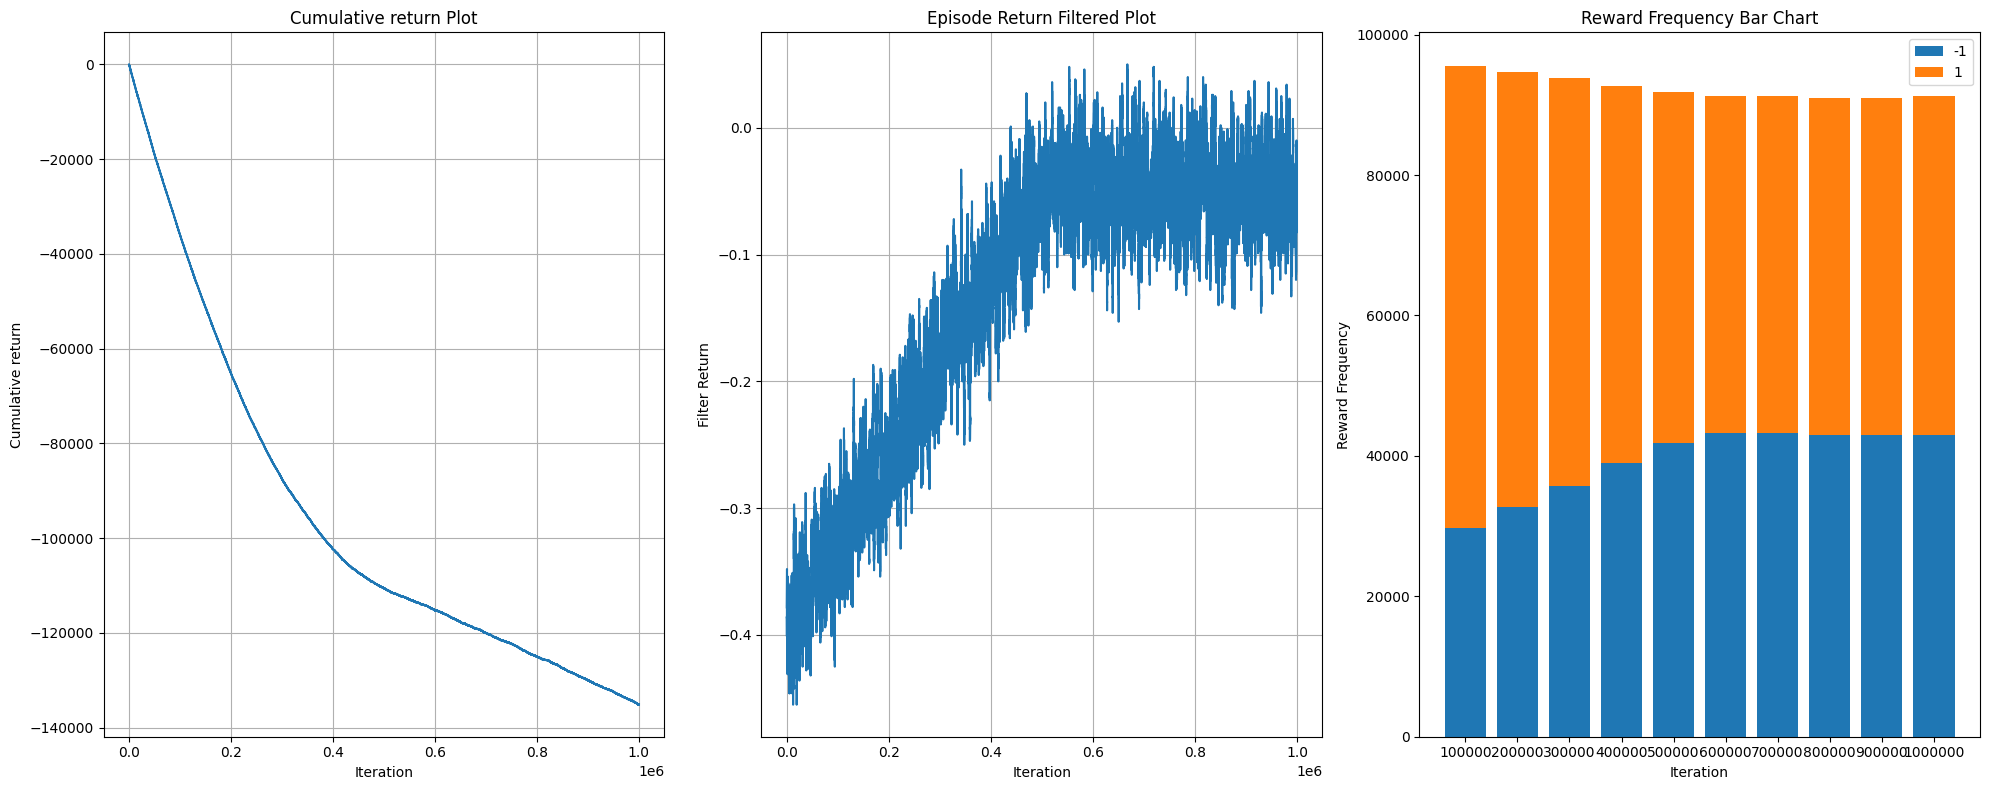

In [41]:
Training_Q_Learning_Culmulative_Return_np, Training_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_Q_Learning_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_Q_Learning_reward_moving_average)

## Testing Algorithm Performance After Q-Learning iterations training

Load Agent

In [42]:
#Load Double Q-Learning Agent

# hyperparameters
learning_rate = 0.001
n_episodes = 100000
start_epsilon = 0.001
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "q_learning.json"
agent.load_model(full_path, q_value_file)

defaultdict(<function blackjack.BlackJackAgent.__init__.<locals>.<lambda>()>,
            {(23, 4, 0): [0.0, 0.0],
             (19, 4, 0): [0.3945127342767831, -0.8385080453639636],
             (15, 10, 0): [-0.6645013737360068, -0.5720715664659047],
             (18, 10, 0): [-0.2436611681759534, -0.7751180093951922],
             (12, 10, 0): [-0.5883927341841784, -0.36023898505838364],
             (20, 5, 0): [0.6762175244033518, -0.8811949783741003],
             (11, 1, 0): [-0.7382559502083718, -0.0006673134353077132],
             (8, 10, 0): [-0.572813791484307, -0.0029787260982184057],
             (10, 4, 0): [-0.1929432315668565, 0.0029577438037159],
             (30, 3, 0): [0.0, 0.0],
             (20, 3, 0): [0.6823936649764075, -0.9287333844772521],
             (18, 5, 0): [0.16700166464466906, -0.8058079482814985],
             (8, 5, 0): [-0.18852284919741974, 0.0001401846336931847],
             (17, 7, 0): [-0.10183606723614856, -0.6489074543301855],
            

In [43]:
#Testing Q-Learning 
env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

  1%|          | 1145/100000 [00:00<00:17, 5720.73it/s]

100%|██████████| 100000/100000 [00:17<00:00, 5841.76it/s]


## Visualizing the testing with Q-Learning Algorithm




====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.4375 negative:0.4711
Iteration[10000:20000]     positive:0.4343 negative:0.4811
Iteration[20000:30000]     positive:0.4235 negative:0.4854
Iteration[30000:40000]     positive:0.4256 negative:0.4812
Iteration[40000:50000]     positive:0.4295 negative:0.4775
Iteration[50000:60000]     positive:0.4322 negative:0.4785
Iteration[60000:70000]     positive:0.4304 negative:0.4795
Iteration[70000:80000]     positive:0.4305 negative:0.4764
Iteration[80000:90000]     positive:0.429 negative:0.4799
Iteration[90000:100000]     positive:0.4371 negative:0.479

====================== Reward Frequency ======================


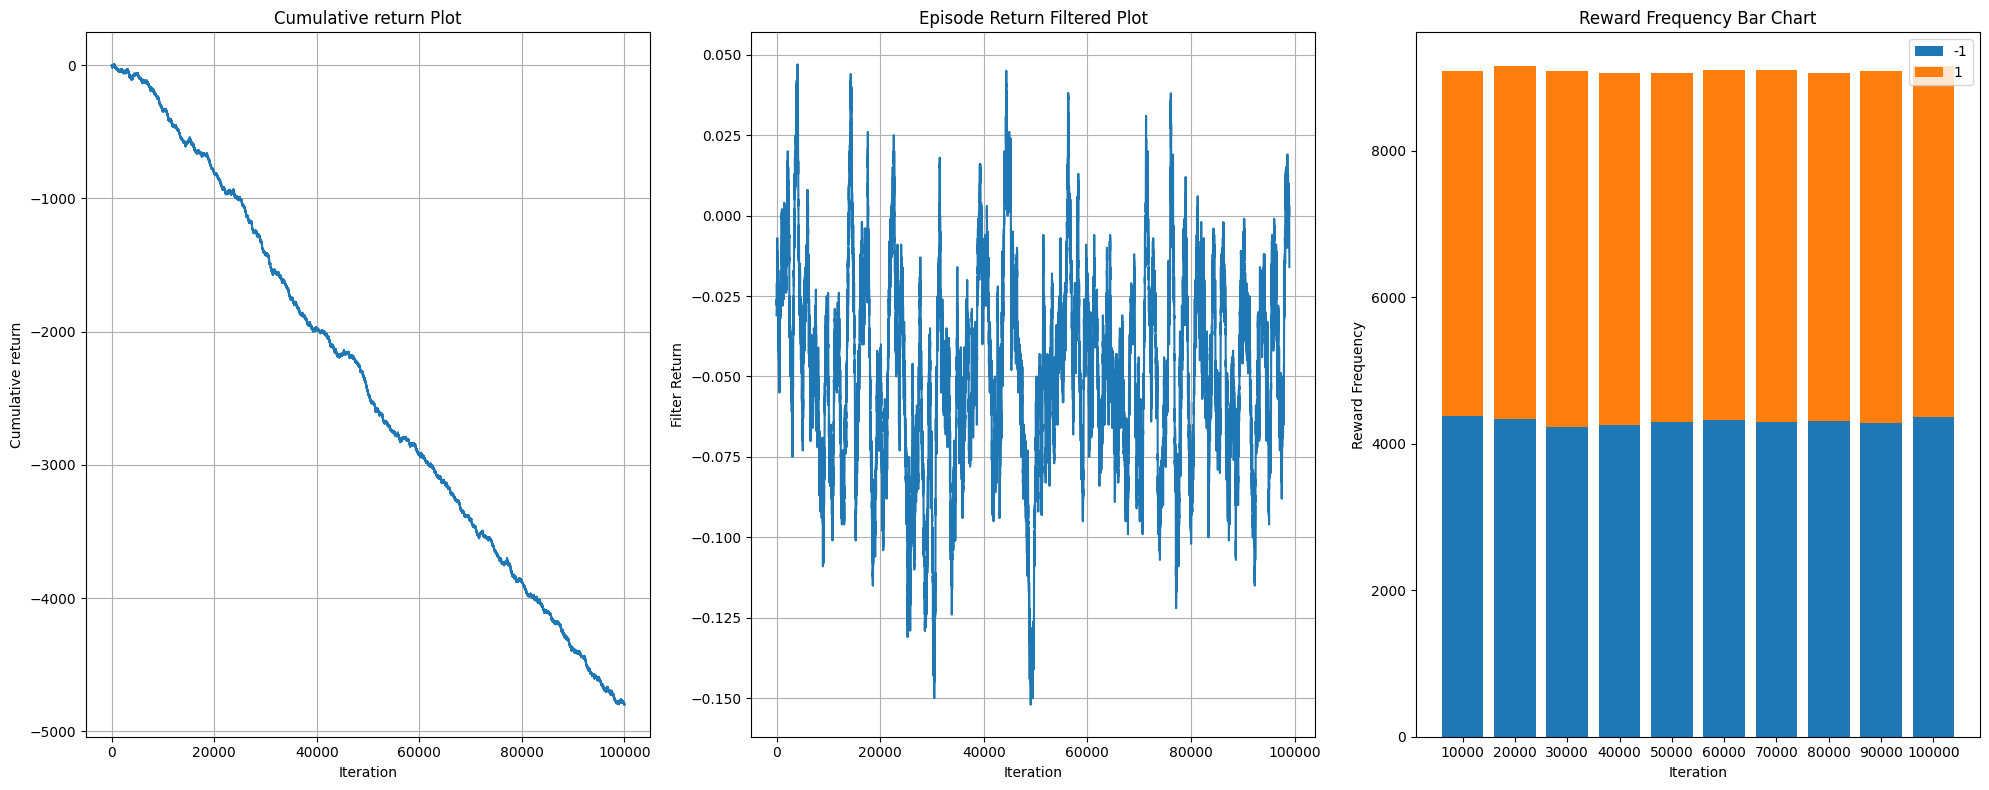

In [44]:
Testing_Q_Learning_Culmulative_Return_np, Testing_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Testing_Culmulative_Return_ls.append(Testing_Q_Learning_Culmulative_Return_np)
Testing_reward_moving_average_ls.append(Testing_Q_Learning_reward_moving_average)

## Visualising the policy



<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




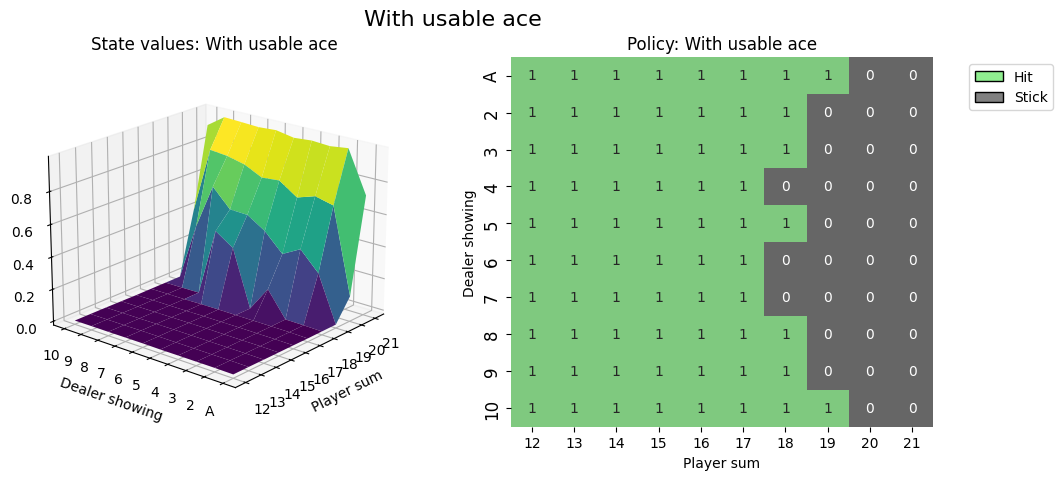

In [45]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

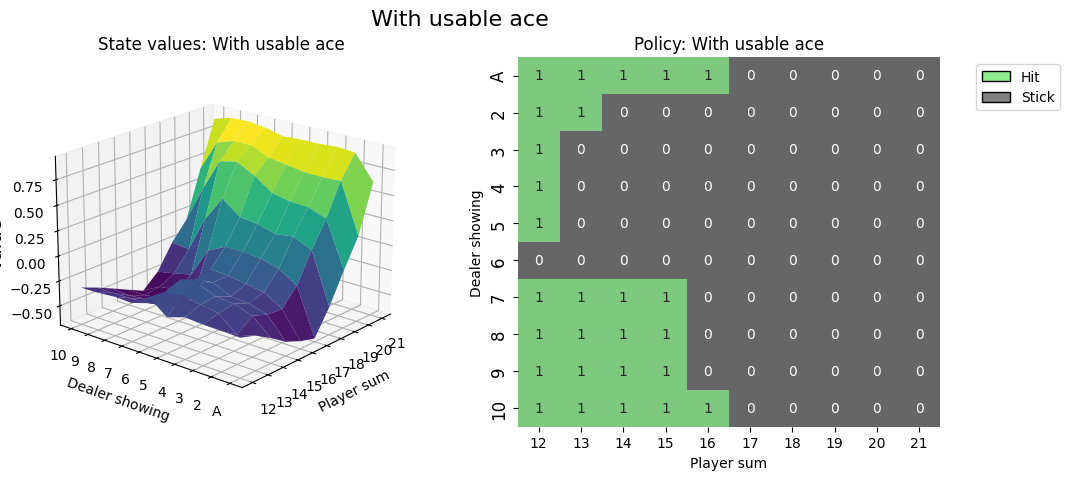

In [46]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# MC Control

## Parameters Studies for MC Algorithm

Discount 

100%|██████████| 10000/10000 [00:02<00:00, 4214.29it/s]


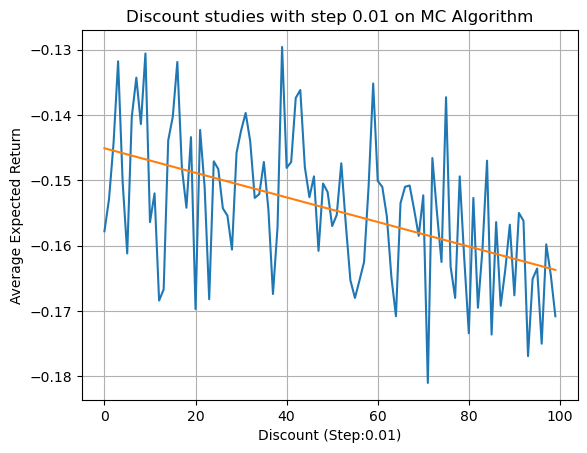

In [17]:
#Discount Hyper Paramter Studied
Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type = ControlType.MONTE_CARLO

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        history_ls = []

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )
        
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on MC Algorithm'.format(discount_step))
plt.grid(True)
plt.show()
    

Epsilon

100%|██████████| 10000/10000 [00:02<00:00, 4897.23it/s]


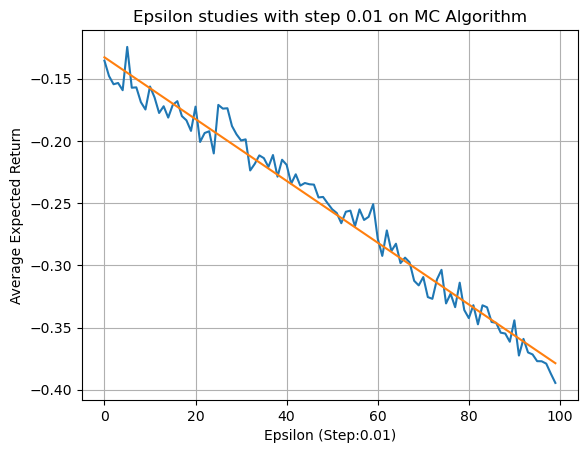

In [18]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,epsilon_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i

    discount = 0.01

    control_type = ControlType.MONTE_CARLO

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        history_ls = []

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )
        
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on MC Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [2]:
#Training MC

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 1.0

control_type = ControlType.MONTE_CARLO

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=True)

Expected_Return = 0
count = 1

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())

  1%|          | 898/100000 [00:00<00:21, 4505.24it/s]

100%|██████████| 100000/100000 [00:19<00:00, 5001.69it/s]


Save Agent

In [48]:
#Save MC agent
q_value_file = "monte_carlo.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with MC Algorithm

====================== Reward Frequency ======================

Iteration[0:100000]     positive:0.29716 negative:0.65889
Iteration[100000:200000]     positive:0.32832 negative:0.61821
Iteration[200000:300000]     positive:0.36052 negative:0.57685
Iteration[300000:400000]     positive:0.38669 negative:0.54123
Iteration[400000:500000]     positive:0.41774 negative:0.50088
Iteration[500000:600000]     positive:0.4334 negative:0.48072
Iteration[600000:700000]     positive:0.43289 negative:0.48081
Iteration[700000:800000]     positive:0.43179 negative:0.48342
Iteration[800000:900000]     positive:0.43532 negative:0.48058
Iteration[900000:1000000]     positive:0.43279 negative:0.48118

====================== Reward Frequency ======================


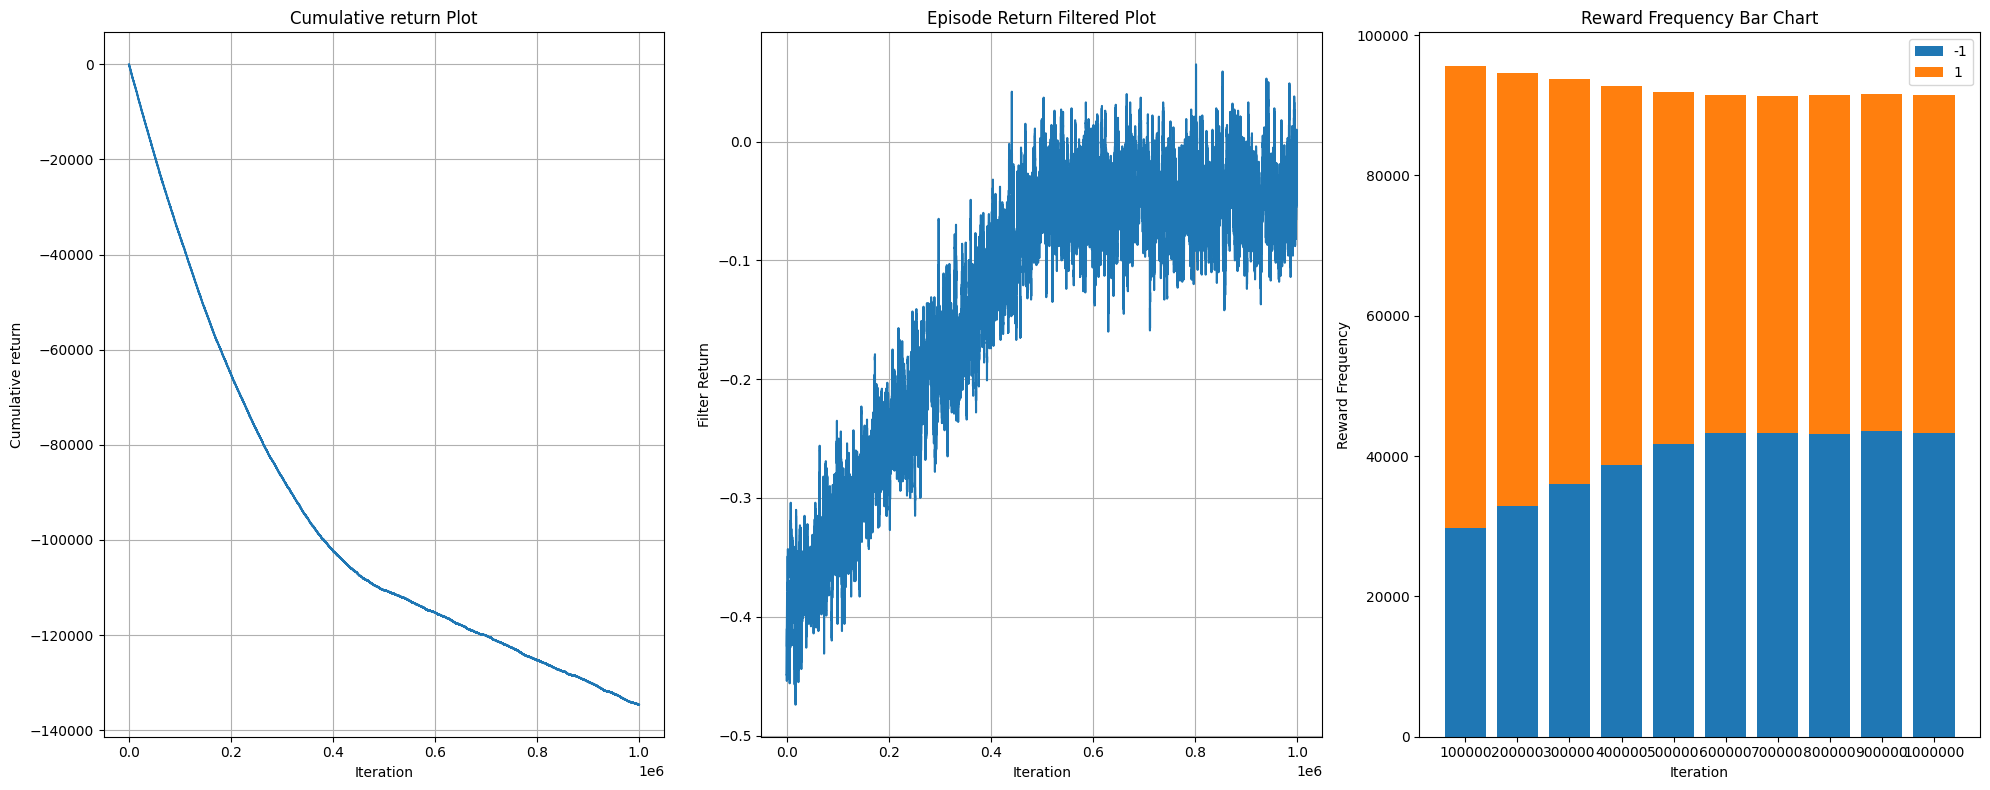

In [49]:
Training_MC_Culmulative_Return_np, Training_MC_reward_moving_average  = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_MC_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_MC_reward_moving_average)

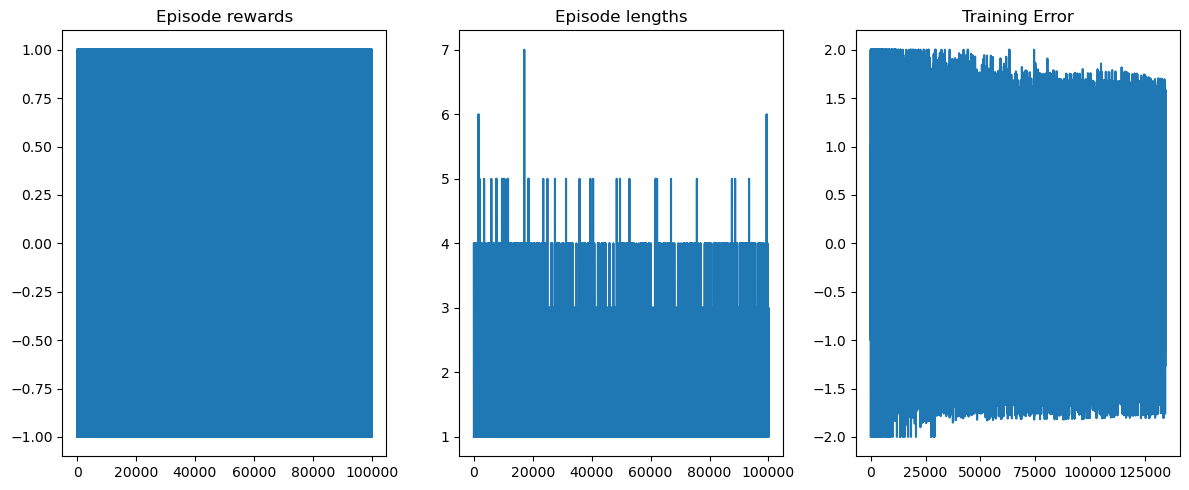

In [3]:
training_plot(env.return_queue, env.length_queue, agent.training_error, 1)

In [4]:
mean_training_error = np.mean(agent.training_error)
print("Mean: ", mean_training_error)

bias = np.mean((agent.training_error - mean_training_error) ** 2)
print("Bias: ", bias)

variance = np.var(agent.training_error)
print("Variance: ", variance)

Mean:  0.018597394309609626
Bias:  0.7081290604569732
Variance:  0.7081290604569732


In [60]:
error = agent.training_error

## Testing Algorithm Performance After 100000 iterations training

Load Agent

In [3]:
#Load MC Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.001
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 1.0

control_type = ControlType.MONTE_CARLO

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "monte_carlo.json"
agent.load_model(full_path, q_value_file)

defaultdict(<function blackjack.BlackJackAgent.__init__.<locals>.<lambda>()>,
            {(16, 4, 0): [-0.22425773847125702, -0.6036748579481388],
             (20, 9, 0): [0.7524932003626462, -0.9139553314121038],
             (17, 9, 0): [-0.4251114592119533, -0.6925621890594995],
             (17, 9, 1): [-0.4484848484848485, -0.0014056042786479803],
             (16, 7, 0): [-0.4582323683203668, -0.5914783047337268],
             (14, 6, 0): [-0.15257672264041722, -0.4610655488647582],
             (13, 6, 0): [-0.15686544553091872, -0.38606361974306225],
             (12, 1, 0): [-0.7729941291585114, -0.31512538066108364],
             (9, 1, 0): [-0.6638655462184874, -0.0030303475967195],
             (21, 10, 0): [0.8885361075457658, -1.0],
             (12, 10, 0): [-0.5816837586453617, -0.31259215194596285],
             (17, 3, 0): [-0.10587054691419973, -0.703880768065268],
             (14, 10, 0): [-0.5619815122066848, -0.46223919201995],
             (13, 10, 0): [-0.581

In [3]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.001
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 1.0

control_type = ControlType.MONTE_CARLO

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

In [5]:
# Testing MC

env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()

    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:18<00:00, 5301.76it/s]


## Visualizing the testing with MC Algorithm




====================== Reward Frequency ======================

Iteration[0:100000]     positive:0.30128 negative:0.65498
Iteration[100000:200000]     positive:0.33092 negative:0.61902
Iteration[200000:300000]     positive:0.36085 negative:0.58327
Iteration[300000:400000]     positive:0.39253 negative:0.54435
Iteration[400000:500000]     positive:0.41471 negative:0.51677
Iteration[500000:600000]     positive:0.42912 negative:0.49927
Iteration[600000:700000]     positive:0.43107 negative:0.49707
Iteration[700000:800000]     positive:0.42845 negative:0.49895
Iteration[800000:900000]     positive:0.42805 negative:0.49925
Iteration[900000:1000000]     positive:0.4288 negative:0.49772

====================== Reward Frequency ======================


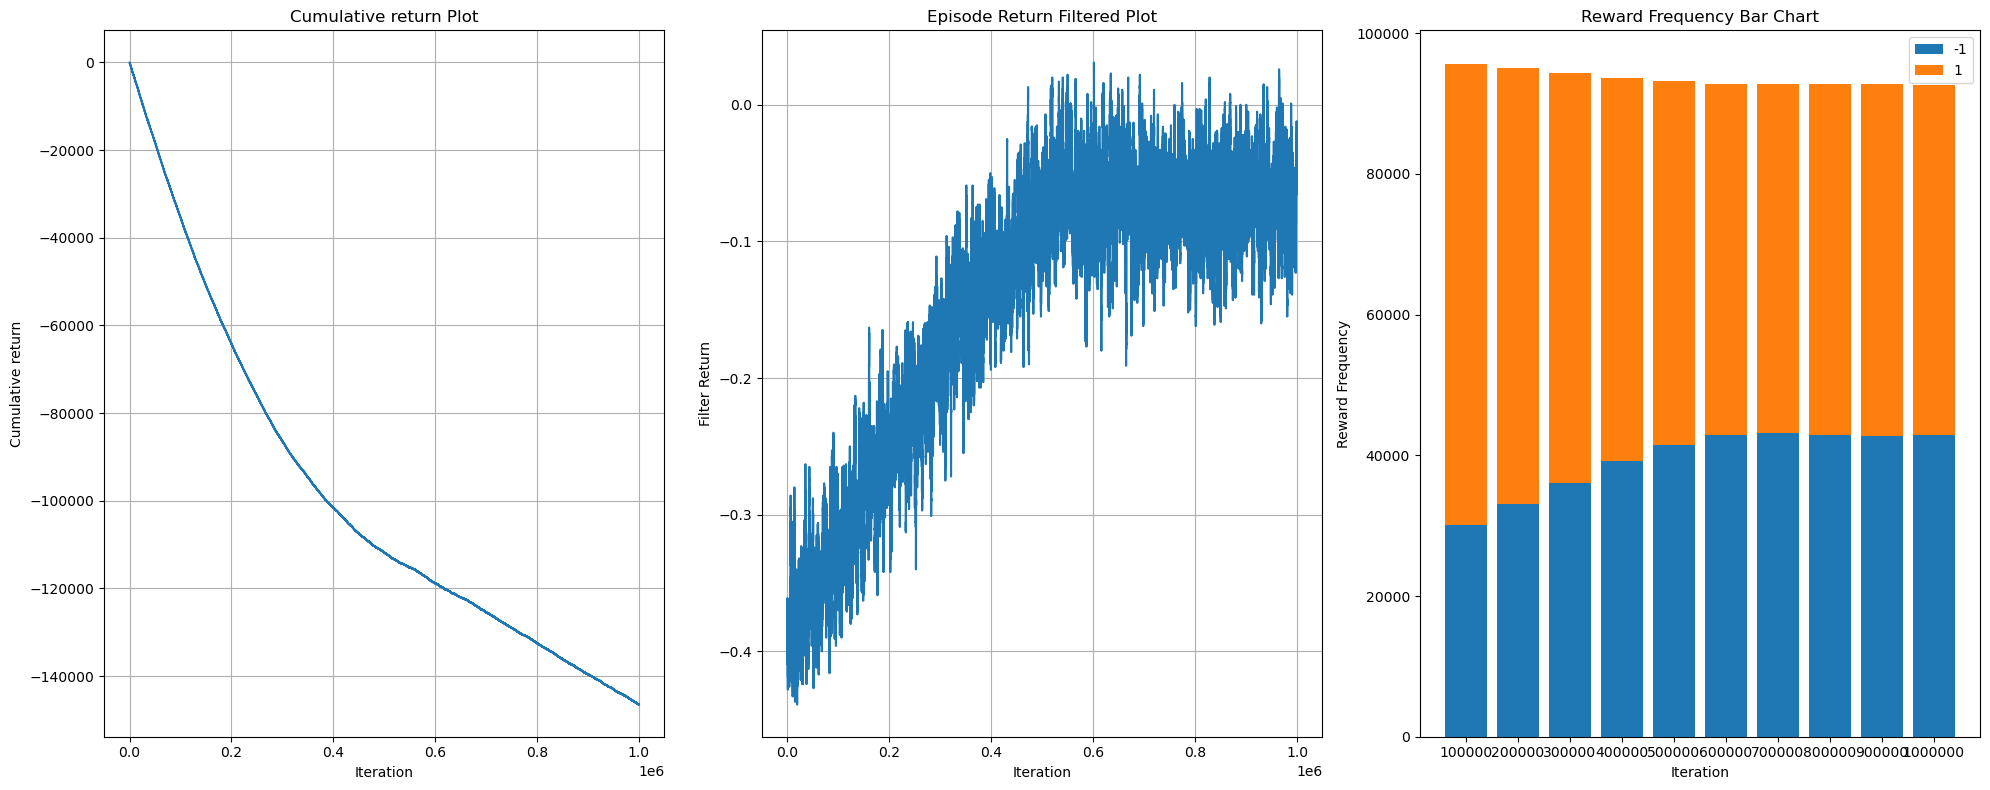

In [38]:
Testing_MC_Culmulative_Return_np, Testing_MC_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
# Testing_Culmulative_Return_ls.append(Testing_MC_Culmulative_Return_np)
# Testing_reward_moving_average_ls.append(Testing_MC_reward_moving_average)

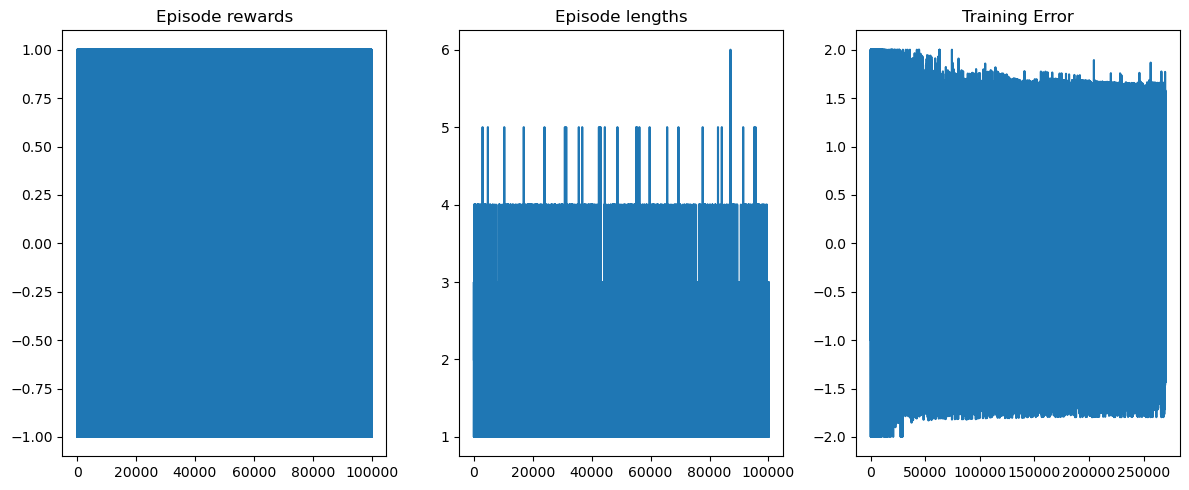

In [6]:
training_plot(env.return_queue, env.length_queue, agent.training_error, 1)

In [7]:
mean_training_error = np.mean(agent.training_error)
print("Mean: ", mean_training_error)

bias = np.mean((agent.training_error - mean_training_error) ** 2)
print("Bias: ", bias)

variance = np.var(agent.training_error)
print("Variance: ", variance)

Mean:  0.014043852895332793
Bias:  0.7137597409415212
Variance:  0.7137597409415212


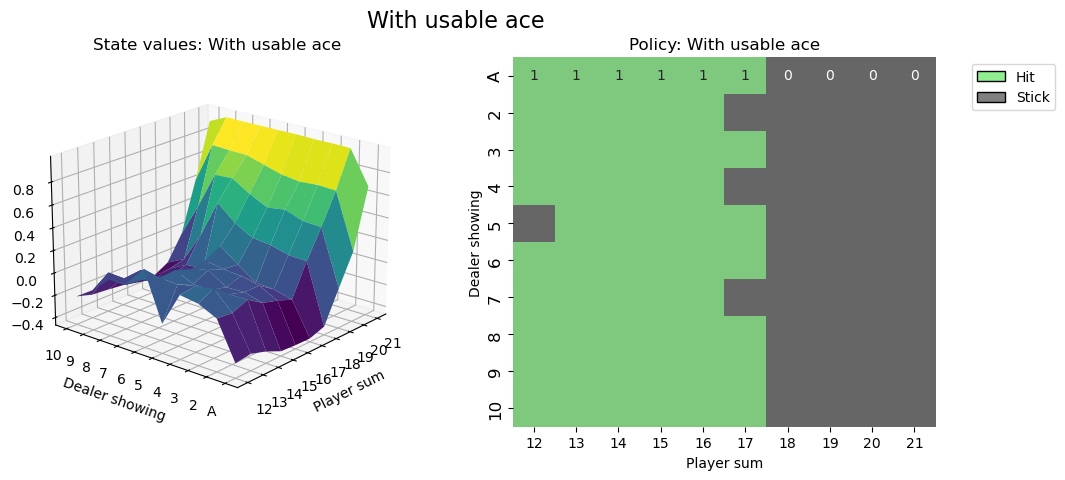

In [43]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

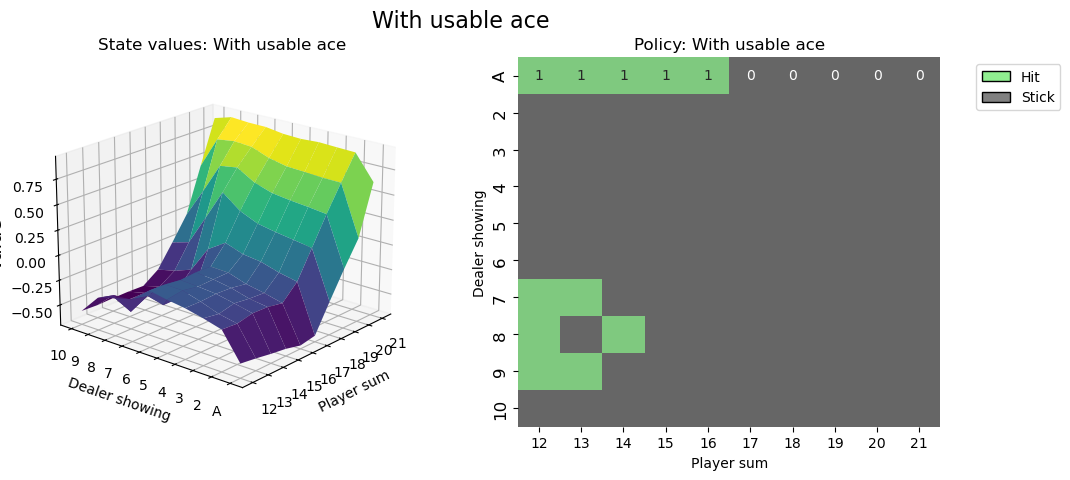

In [44]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

## TD Control

## Parameters Studies for SARSA Algorithm

Discount 

100%|██████████| 10000/10000 [00:01<00:00, 5027.86it/s]


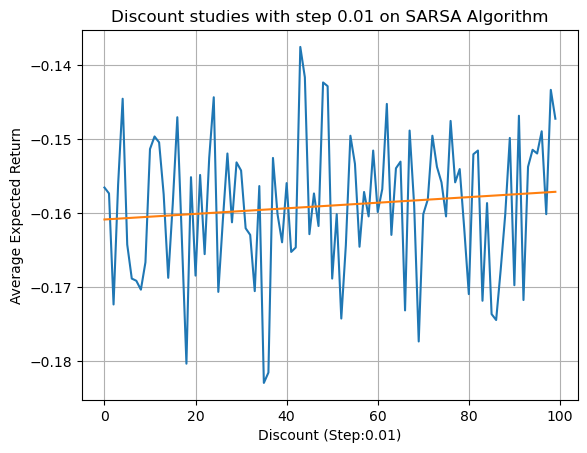

In [27]:
#Discount Hyper Paramter Studied

Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type = ControlType.TEMPORAL_DIFFERENCE

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # Choose a from s using policy derived from Q
        action = agent.get_action(obs)

        # play one episode
        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_action = agent.get_action(next_obs)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            action = next_action

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on SARSA Algorithm'.format(discount_step))
plt.grid(True)
plt.show()

Epsilon

100%|██████████| 10000/10000 [00:02<00:00, 4711.32it/s]


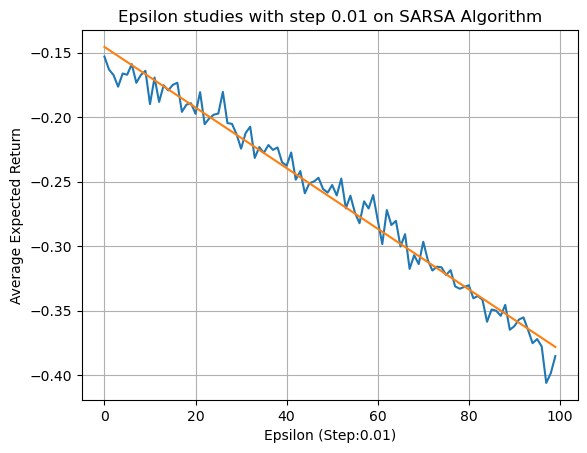

In [28]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,discount_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i
    discount = 0.01

    control_type = ControlType.TEMPORAL_DIFFERENCE

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # Choose a from s using policy derived from Q
        action = agent.get_action(obs)

        # play one episode
        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_action = agent.get_action(next_obs)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            action = next_action

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on SARSA Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

Learning Rate

  9%|▉         | 941/10000 [00:00<00:01, 4721.51it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4923.82it/s]


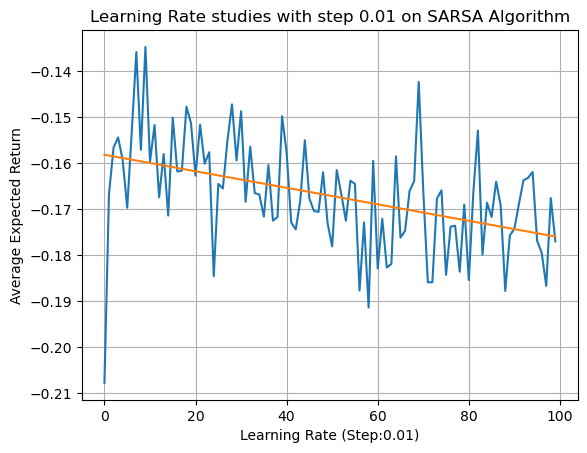

In [29]:
#Learning Rate Hyper Paramter Studied
Expected_Return_ls = []
learning_rate_step = 0.01
learning_rate_ls = np.arange(0,1,discount_step)

for i in  learning_rate_ls:
    # hyperparameters
    learning_rate = i
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = 0.01

    control_type = ControlType.TEMPORAL_DIFFERENCE

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # Choose a from s using policy derived from Q
        action = agent.get_action(obs)

        # play one episode
        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_action = agent.get_action(next_obs)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            action = next_action

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Learning Rate (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Learning Rate studies with step {} on SARSA Algorithm'.format(learning_rate_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [76]:
#Training SARSA
# hyperparameters
learning_rate = 0.01
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 1.0

control_type = ControlType.TEMPORAL_DIFFERENCE

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # Choose a from s using policy derived from Q
    action = agent.get_action(obs)

    # play one episode
    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_action = agent.get_action(next_obs)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            next_action=next_action,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        action = next_action

    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [02:50<00:00, 5863.95it/s]


Save Agent

In [77]:
#Save SARSA agent
q_value_file = "temporal_difference.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with SARSA Algorithm

In [78]:
# for i in range(2):
#     Testing_Culmulative_Return_ls.pop()
#     Testing_reward_moving_average_ls.pop()
len(Training_reward_moving_average_ls)

2

====================== Reward Frequency ======================

Iteration[0:100000]     positive:0.29826 negative:0.65794
Iteration[100000:200000]     positive:0.33192 negative:0.61633
Iteration[200000:300000]     positive:0.35827 negative:0.58043
Iteration[300000:400000]     positive:0.38957 negative:0.5392
Iteration[400000:500000]     positive:0.41682 negative:0.499
Iteration[500000:600000]     positive:0.42961 negative:0.47754
Iteration[600000:700000]     positive:0.42986 negative:0.47662
Iteration[700000:800000]     positive:0.42977 negative:0.47679
Iteration[800000:900000]     positive:0.42995 negative:0.4762
Iteration[900000:1000000]     positive:0.42835 negative:0.47704

====================== Reward Frequency ======================


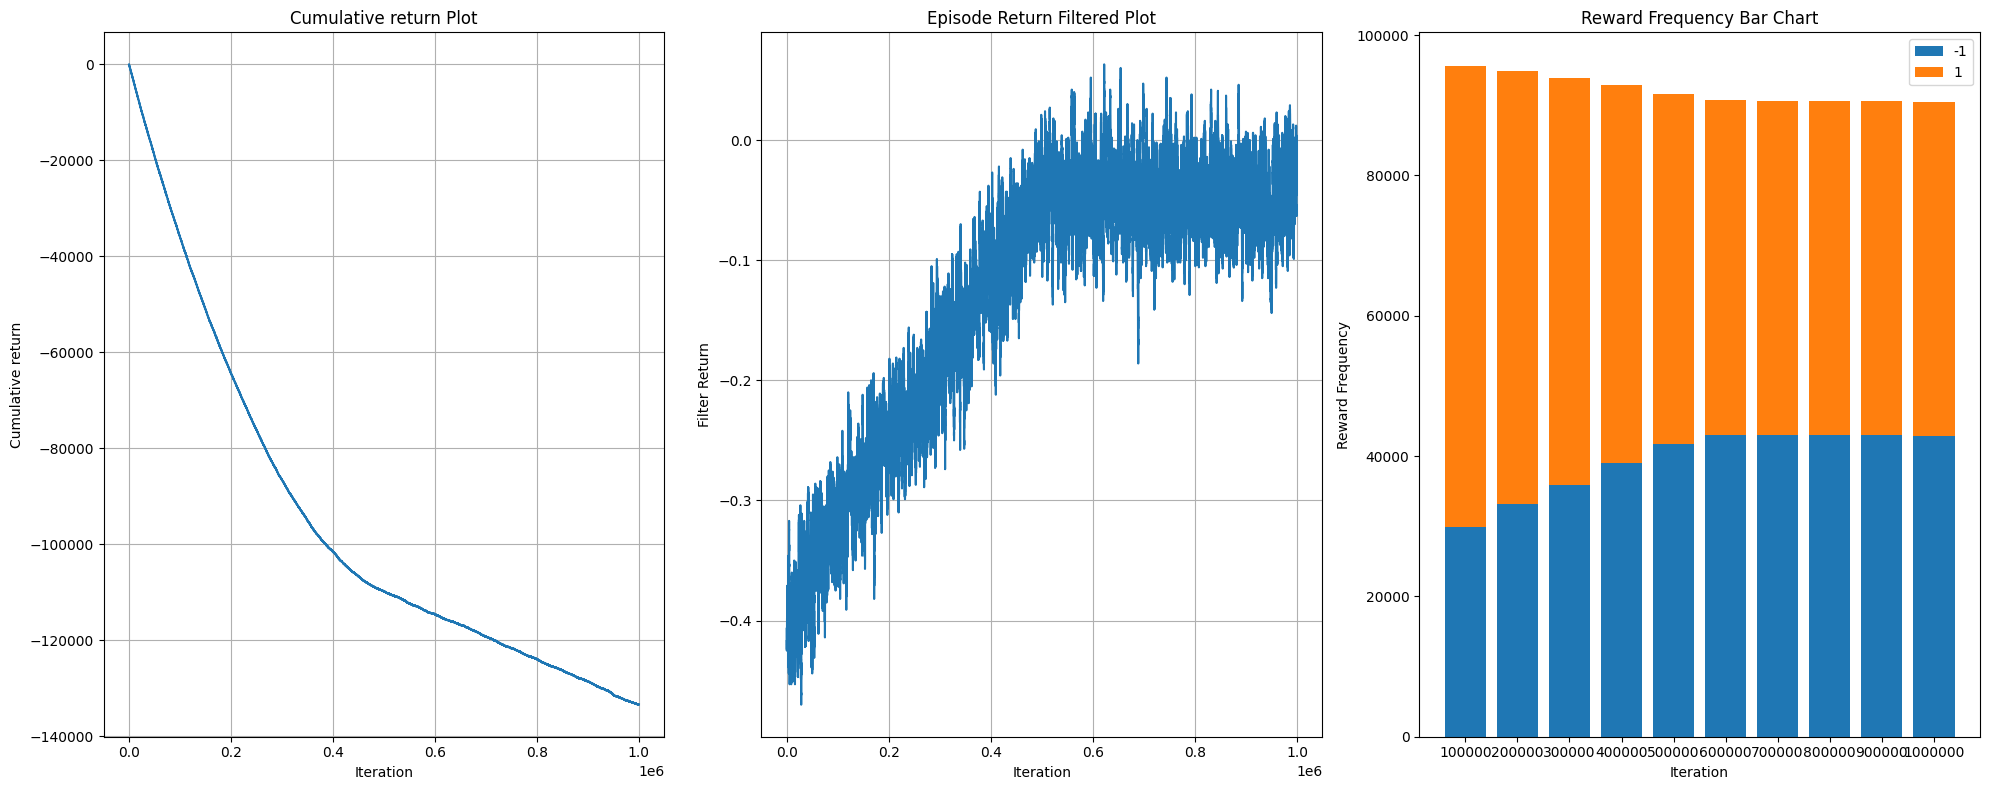

In [79]:
Training_SARSA_Culmulative_Return_np, Training_SARSA_reward_moving_average  = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_SARSA_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_SARSA_reward_moving_average)

Load Agent

In [20]:
#Load SARSA Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.001
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 1.0

control_type = ControlType.TEMPORAL_DIFFERENCE

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "temporal_difference.json"
agent.load_model(full_path, q_value_file)

defaultdict(<function blackjack.BlackJackAgent.__init__.<locals>.<lambda>()>,
            {(19, 7, 0): [0.6506031201624579, -0.7780886868443864],
             (9, 7, 0): [-0.2990949335120283, 0.10843283272708155],
             (21, 8, 1): [0.9950100076340729, 0.07703009798191736],
             (12, 10, 0): [-0.596108588248553, -0.46383558028651667],
             (20, 10, 1): [0.4276016139173316, -0.18515165723314264],
             (14, 7, 0): [-0.4893939305106696, -0.3199675572447593],
             (11, 7, 0): [-0.528793734474164, 0.2791785225125671],
             (17, 10, 0): [-0.4161220280602697, -0.6378683049193574],
             (15, 10, 0): [-0.6997374557281586, -0.49251714559702575],
             (27, 10, 0): [0.0, 0.0],
             (20, 10, 0): [0.4084292427625301, -0.8052028340654911],
             (14, 1, 0): [-0.7989405170030509, -0.5843651432908794],
             (10, 1, 0): [-0.7381215715872173, -0.18141421668075333],
             (24, 1, 0): [0.0, 0.0],
             (13, 

## Testing Algorithm Performance After 100000 iterations training

In [21]:
# Testing SARSA

env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
# np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # Choose a from s using policy derived from Q
    action = agent.get_action(obs)

    # play one episode
    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_action = agent.get_action(next_obs)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            next_action=next_action,
            terminated=terminated
        )
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        action = next_action


100%|██████████| 100000/100000 [00:20<00:00, 4810.27it/s]


## Visualizing the testing with SARSA Algorithm




====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.4212 negative:0.4812
Iteration[10000:20000]     positive:0.43 negative:0.48
Iteration[20000:30000]     positive:0.433 negative:0.4748
Iteration[30000:40000]     positive:0.4265 negative:0.4749
Iteration[40000:50000]     positive:0.4296 negative:0.4804
Iteration[50000:60000]     positive:0.4328 negative:0.4739
Iteration[60000:70000]     positive:0.4235 negative:0.4813
Iteration[70000:80000]     positive:0.4298 negative:0.4811
Iteration[80000:90000]     positive:0.4347 negative:0.4724
Iteration[90000:100000]     positive:0.4295 negative:0.4764

====================== Reward Frequency ======================


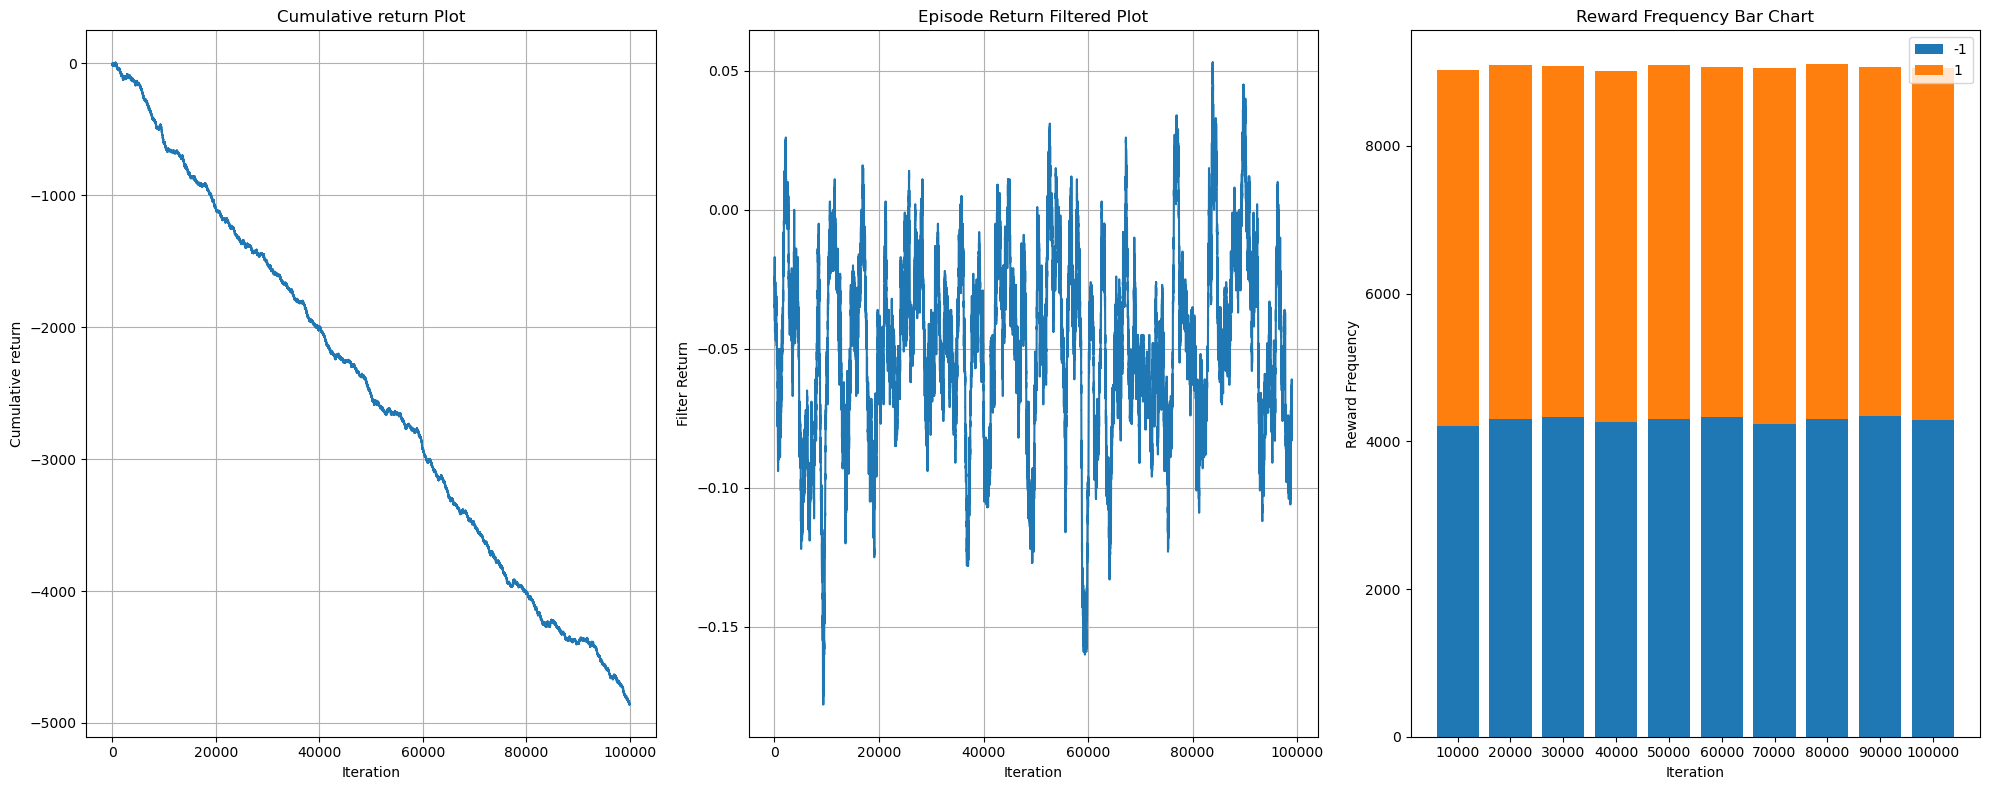

In [9]:
Testing_SARSA_Culmulative_Return_np, Testing_SARSA_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
# Testing_Culmulative_Return_ls.append(Testing_SARSA_Culmulative_Return_np)
# Testing_reward_moving_average_ls.append(Testing_SARSA_reward_moving_average)

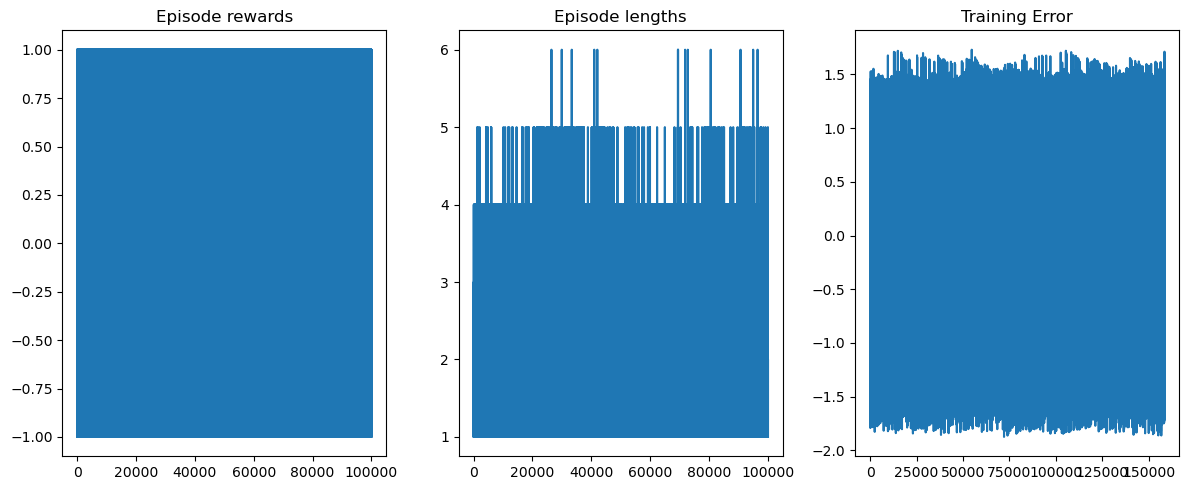

In [22]:
training_plot(env.return_queue, env.length_queue, agent.training_error, 1)

In [23]:
mean_training_error = np.mean(agent.training_error)
print("Mean: ", mean_training_error)

bias = np.mean((agent.training_error - mean_training_error) ** 2)
print("Bias: ", bias)

variance = np.var(agent.training_error)
print("Variance: ", variance)

Mean:  -0.0005677521768530844
Bias:  0.46513612541497784
Variance:  0.46513612541497784


## Visualizing the training




## Visualising the policy



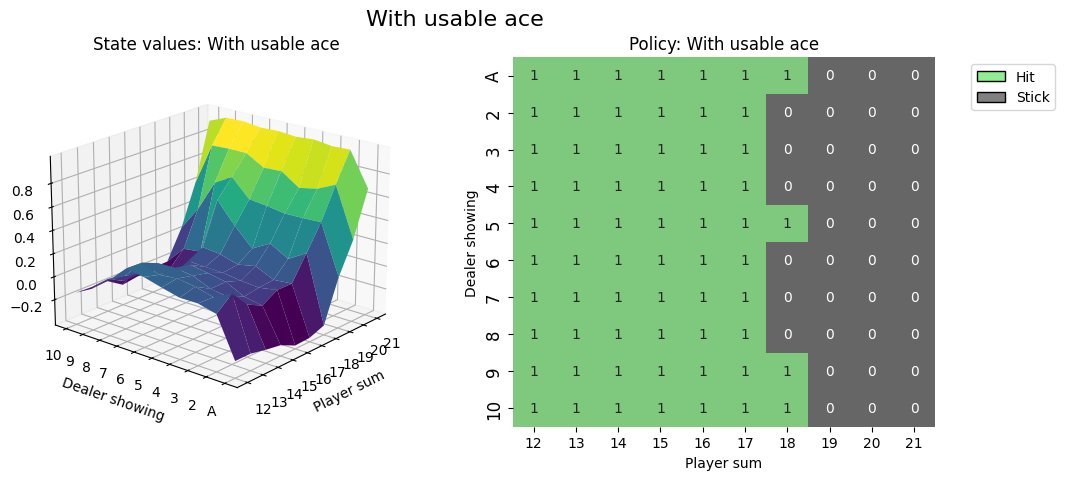

In [83]:
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

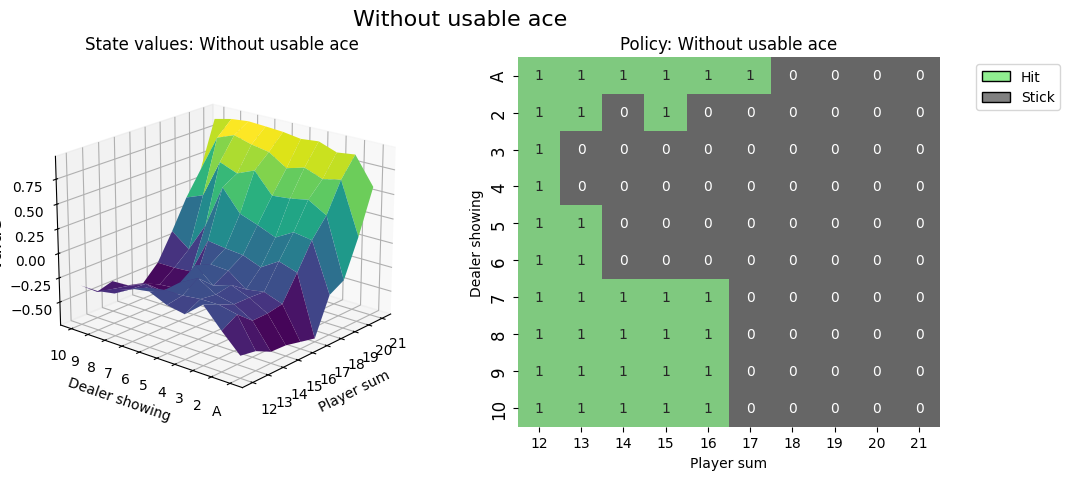

In [84]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

# Double Q-Learning Control

## Parameters Studies for Double Q-Learning Algorithm

Discount 

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 6245.18it/s]


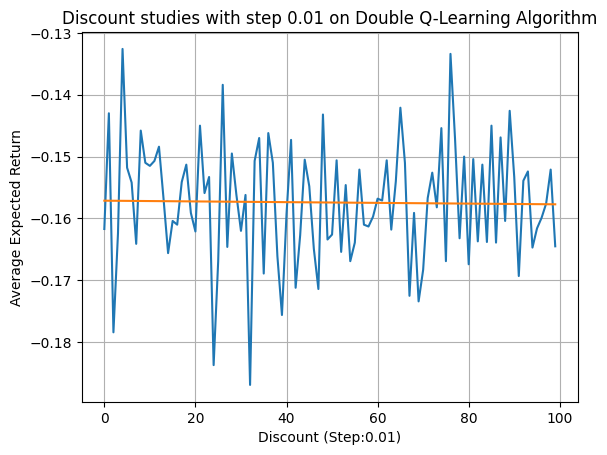

In [38]:
#Discount Hyper Paramter Studied
Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type == ControlType.DOUBLE_Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on Double Q-Learning Algorithm'.format(discount_step))
plt.grid(True)
plt.show()
    

Epsilon

100%|██████████| 10000/10000 [00:01<00:00, 5032.34it/s]


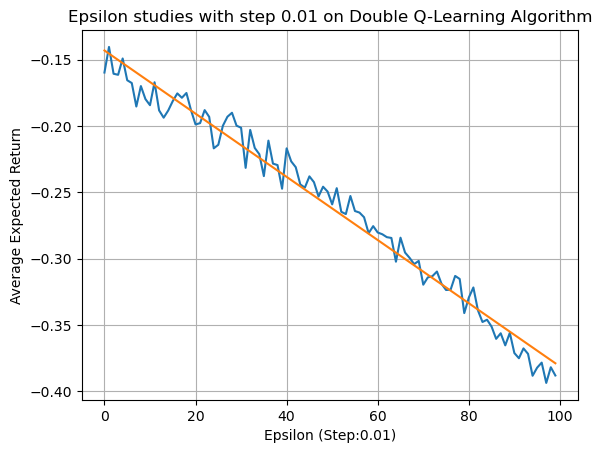

In [41]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,epsilon_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i
    discount = 0.01

    control_type == ControlType.DOUBLE_Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on Double Q-Learning Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

Learning Rate

100%|██████████| 10000/10000 [00:01<00:00, 5041.67it/s]


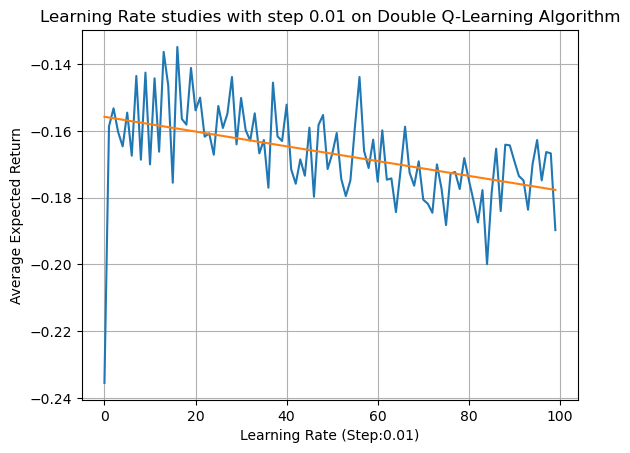

In [42]:
#Learning Rate Hyper Paramter Studied
Expected_Return_ls = []
learning_rate_step = 0.01
learning_rate_ls = np.arange(0,1,learning_rate_step)

for i in  learning_rate_ls:
    # hyperparameters
    learning_rate = i
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = 0.01

    control_type == ControlType.DOUBLE_Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Learning Rate (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Learning Rate studies with step {} on Double Q-Learning Algorithm'.format(learning_rate_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [85]:
#Training Double Q-Learning
# hyperparameters
learning_rate = 0.01
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.DOUBLE_Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 3214/1000000 [00:00<03:08, 5300.59it/s]

100%|██████████| 1000000/1000000 [02:57<00:00, 5621.42it/s]


Save Agent

In [86]:
#Save Double Q-Learning agent
q_value_file = "double_q_learning.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with Double Q-Learning Algorithm

====================== Reward Frequency ======================

Iteration[0:100000]     positive:0.29773 negative:0.65673
Iteration[100000:200000]     positive:0.32805 negative:0.61888
Iteration[200000:300000]     positive:0.35887 negative:0.57889
Iteration[300000:400000]     positive:0.38841 negative:0.54021
Iteration[400000:500000]     positive:0.41832 negative:0.50048
Iteration[500000:600000]     positive:0.42971 negative:0.48628
Iteration[600000:700000]     positive:0.43024 negative:0.47969
Iteration[700000:800000]     positive:0.43114 negative:0.48103
Iteration[800000:900000]     positive:0.42987 negative:0.48272
Iteration[900000:1000000]     positive:0.43383 negative:0.47883

====================== Reward Frequency ======================


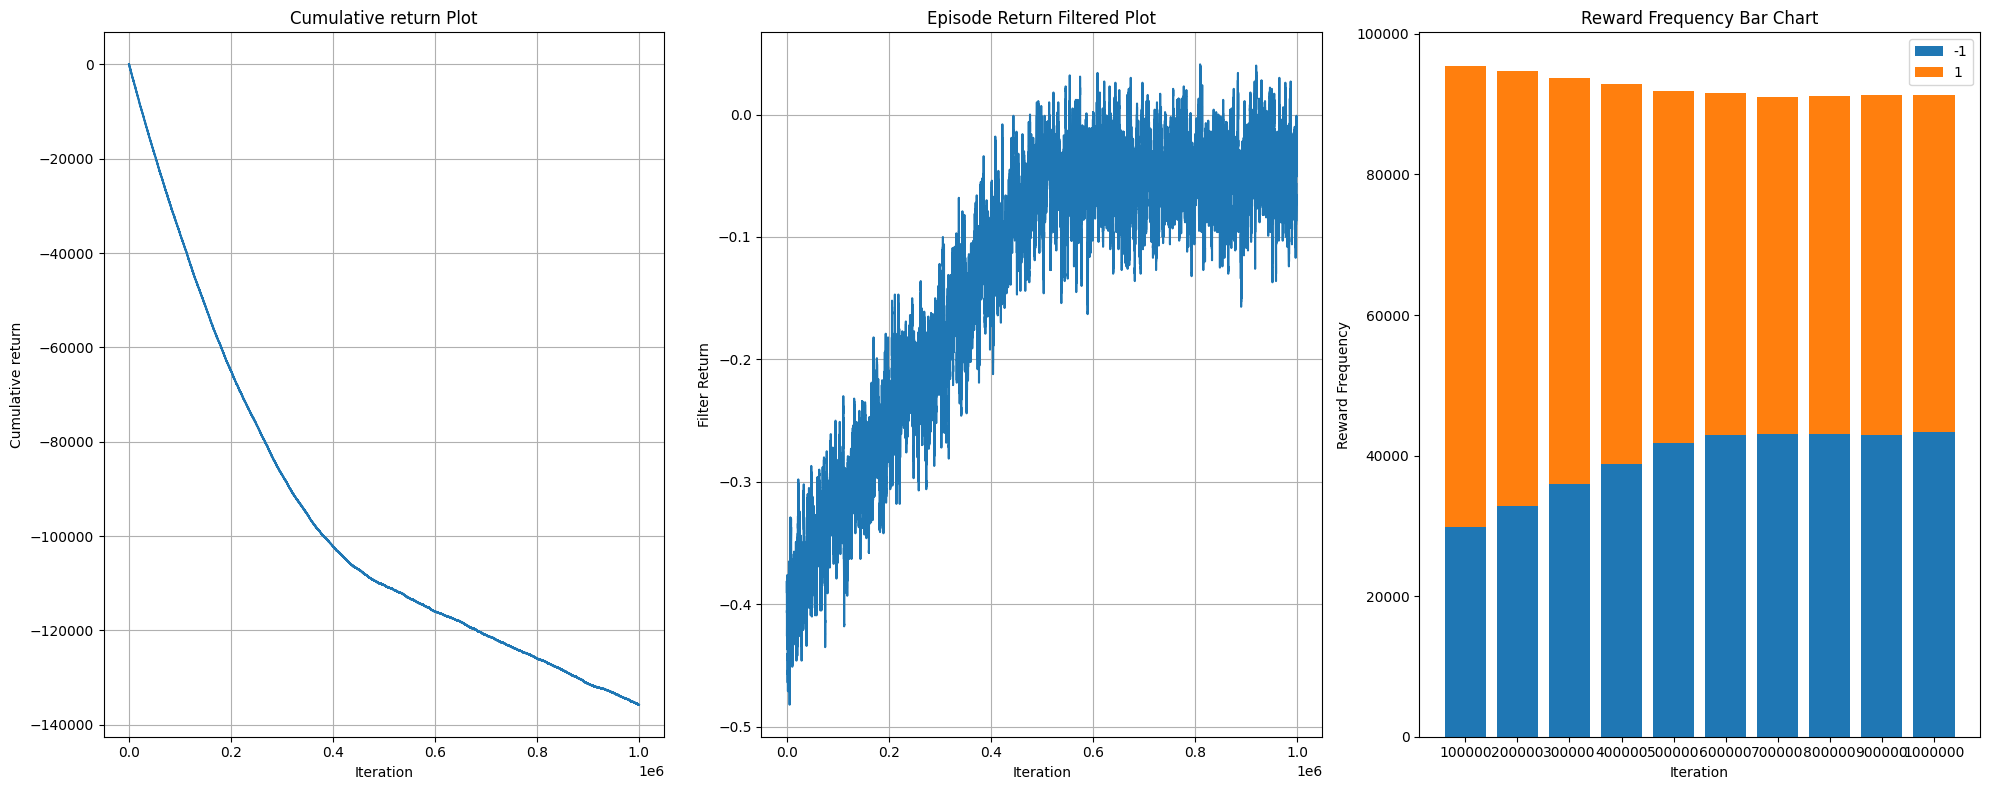

In [87]:
Training_Double_Q_Learning_Culmulative_Return_np, Training_Double_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_Double_Q_Learning_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_Double_Q_Learning_reward_moving_average)

## Testing Algorithm Performance After Double Q-Learning iterations training

Load Agent

In [88]:
#Load Double Q-Learning Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.001
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.DOUBLE_Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "double_q_learning.json"
agent.load_model(full_path, q_value_file)

defaultdict(<function blackjack.BlackJackAgent.__init__.<locals>.<lambda>()>,
            {(17, 6, 1): [-0.0025008900278917804, 0.0013016876756536536],
             (14, 6, 0): [-0.16451018681120888, -0.42712131275116283],
             (14, 10, 1): [-0.48614045338263534, -0.0011731604312604264],
             (14, 7, 1): [-0.23189277173450193, -0.0003259482786555679],
             (11, 10, 0): [-0.5329418823010863, 0.0005413898912361014],
             (20, 10, 1): [0.45232463026361314, -0.00055499915340649],
             (19, 10, 0): [-0.06290854023400778, -0.8539828710982202],
             (21, 10, 0): [0.8704773525171481, -0.9999743802100818],
             (16, 10, 0): [-0.6928981658986926, -0.6106352164335443],
             (20, 3, 0): [0.6691294190487698, -0.8980871463727108],
             (18, 10, 0): [-0.19651896957977022, -0.7837762245629151],
             (9, 10, 0): [-0.5358829827561601, -0.0020392383016073906],
             (12, 10, 0): [-0.5490040058409285, -0.301380597155539

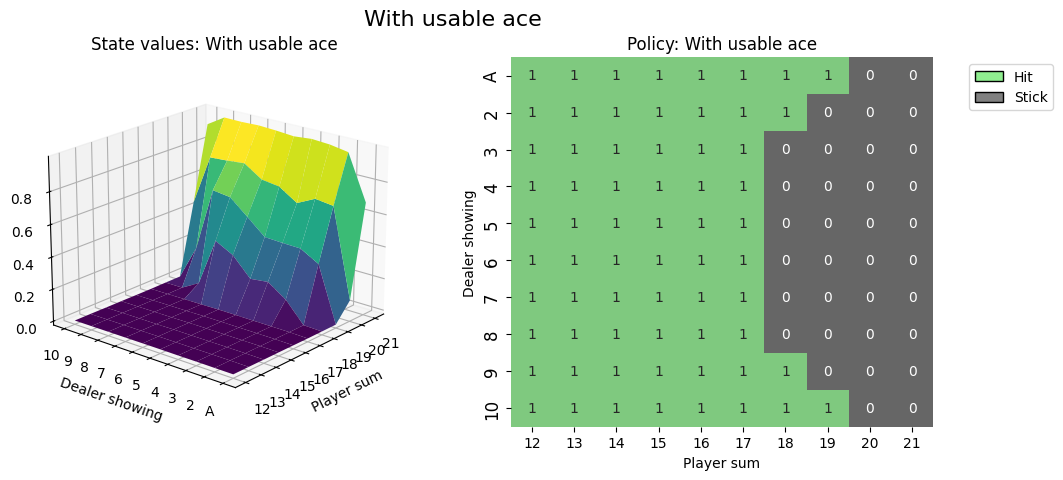

In [89]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

In [90]:
#Testing Double Q-Learning
env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

  1%|          | 567/100000 [00:00<00:17, 5638.90it/s]

100%|██████████| 100000/100000 [00:17<00:00, 5560.05it/s]


## Visualizing the testing with Double Q-Learning Algorithm




====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.4325 negative:0.4795
Iteration[10000:20000]     positive:0.4381 negative:0.4726
Iteration[20000:30000]     positive:0.4337 negative:0.4783
Iteration[30000:40000]     positive:0.4342 negative:0.4825
Iteration[40000:50000]     positive:0.429 negative:0.4835
Iteration[50000:60000]     positive:0.4379 negative:0.477
Iteration[60000:70000]     positive:0.4323 negative:0.4796
Iteration[70000:80000]     positive:0.4329 negative:0.4843
Iteration[80000:90000]     positive:0.434 negative:0.4823
Iteration[90000:100000]     positive:0.4306 negative:0.4849

====================== Reward Frequency ======================


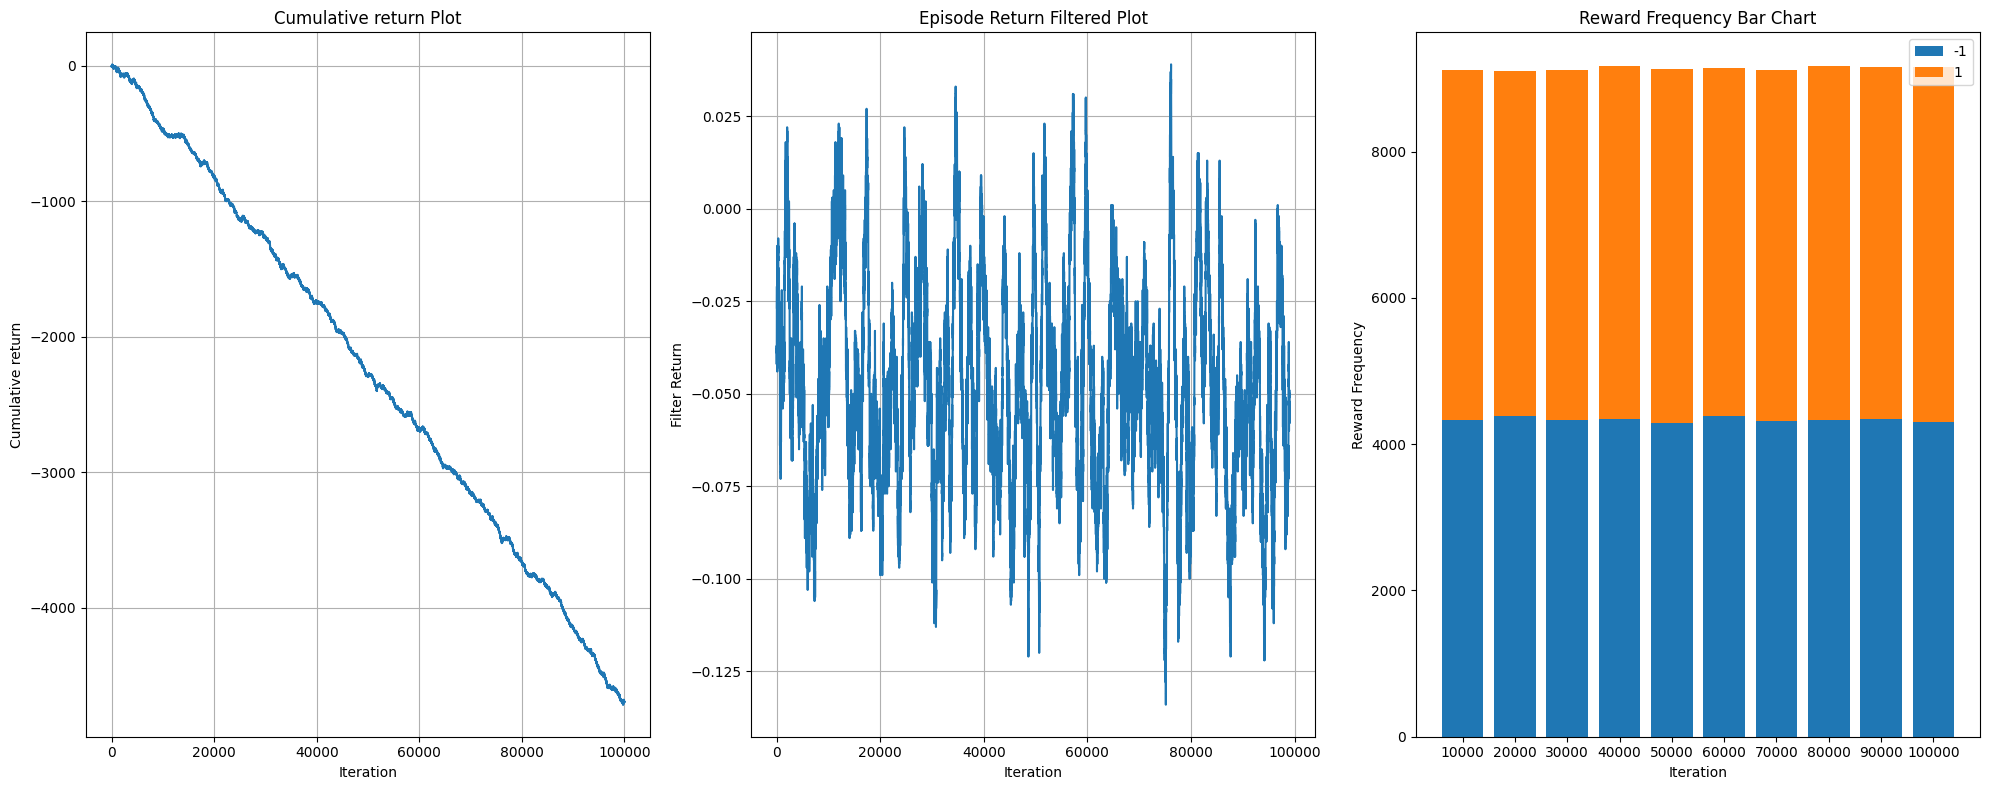

In [91]:
Testing_Double_Q_Learning_Culmulative_Return_np, Testing_Double_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Testing_Culmulative_Return_ls.append(Testing_Double_Q_Learning_Culmulative_Return_np)
Testing_reward_moving_average_ls.append(Testing_Double_Q_Learning_reward_moving_average)

## Visualising the policy



<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




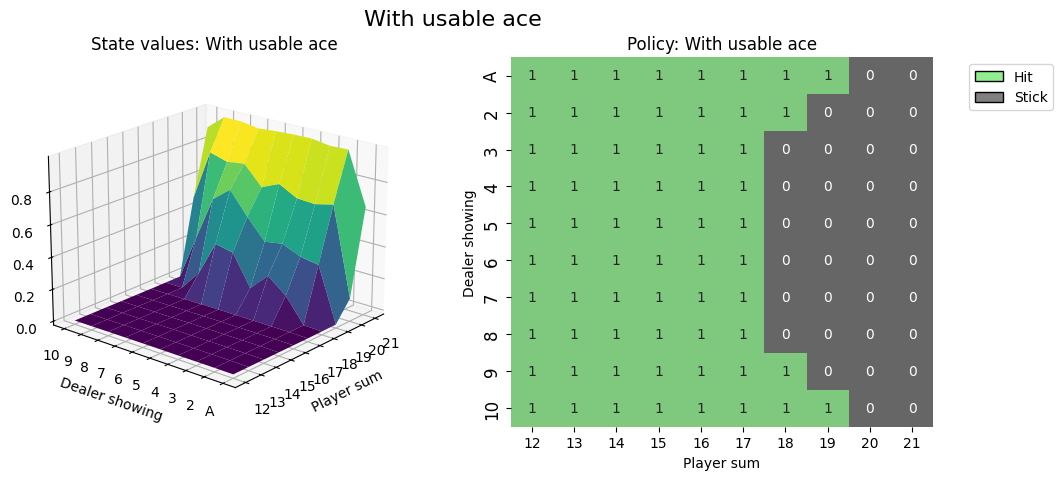

In [92]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

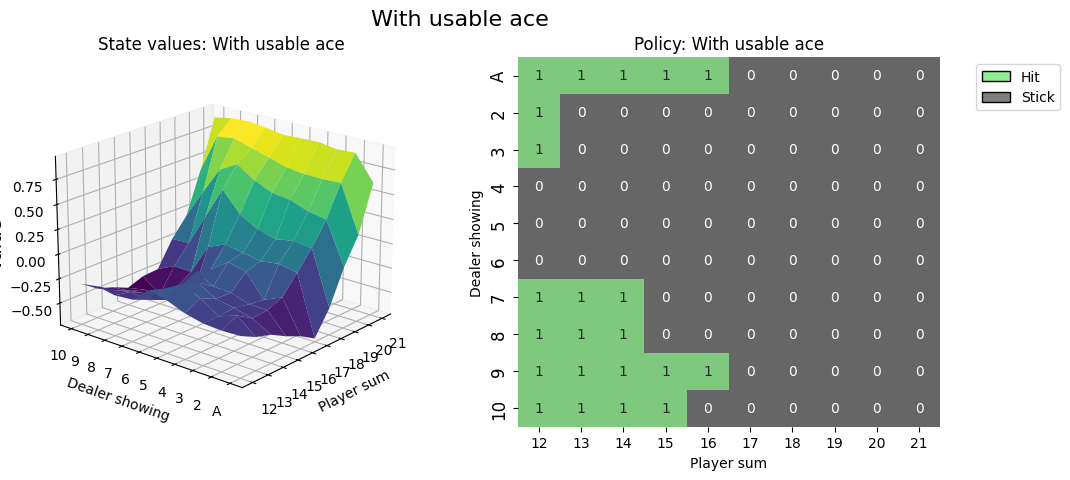

In [93]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# Compare 4 algorithms (Q-Learning, MC, TD, Double Q-Learning) 

============= Expected Return =============
Q-Learning:  -0.135179
MC:  -0.134615
SARSA:  -0.133471
Double Q-Learning:  -0.135757
============= Expected Return =============


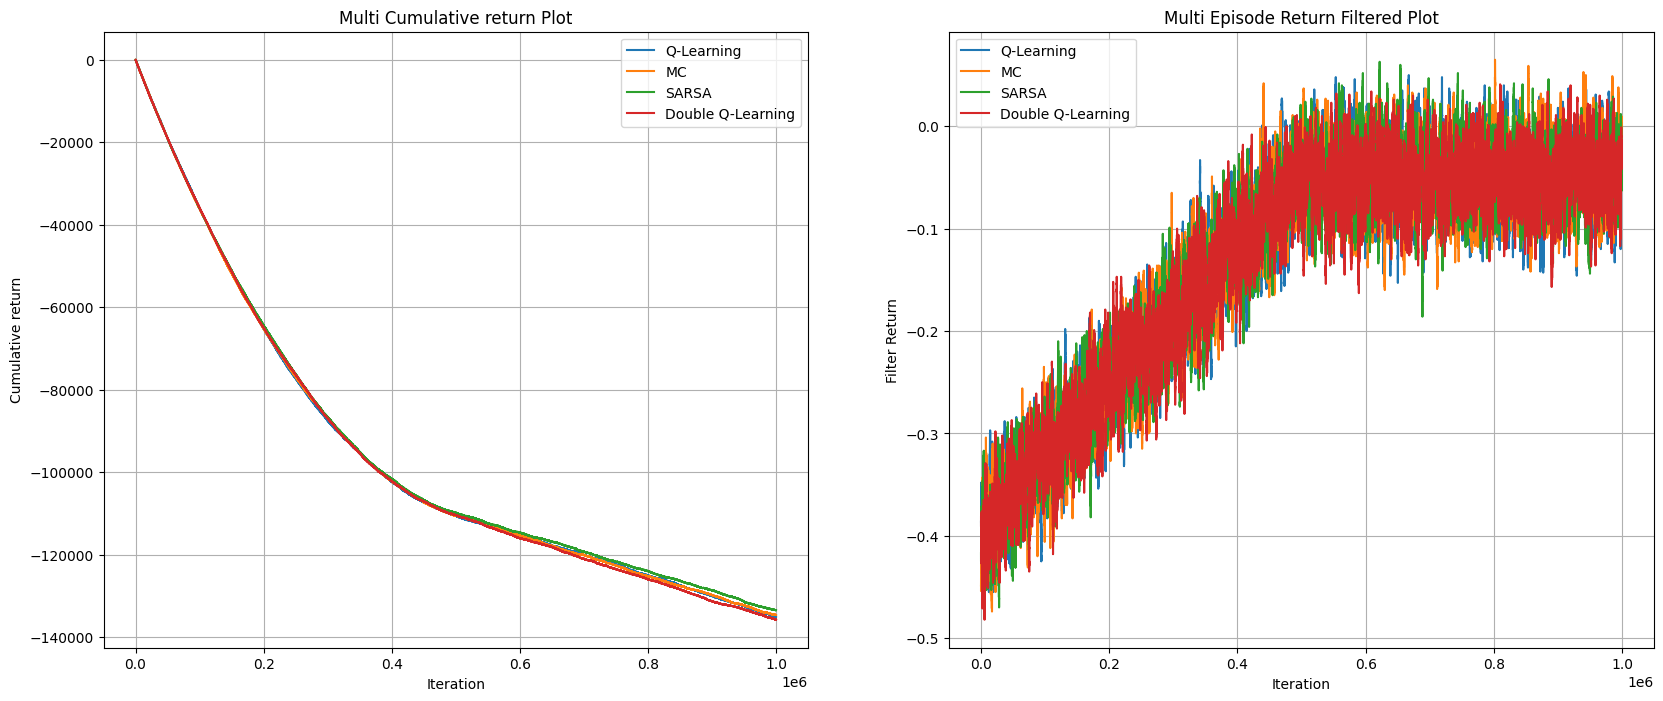

In [94]:
reward_compare_plot(Training_Culmulative_Return_ls, Training_reward_moving_average_ls)

============= Expected Return =============
Q-Learning:  -0.048
MC:  -0.04802
SARSA:  -0.04315
Double Q-Learning:  -0.04693
============= Expected Return =============


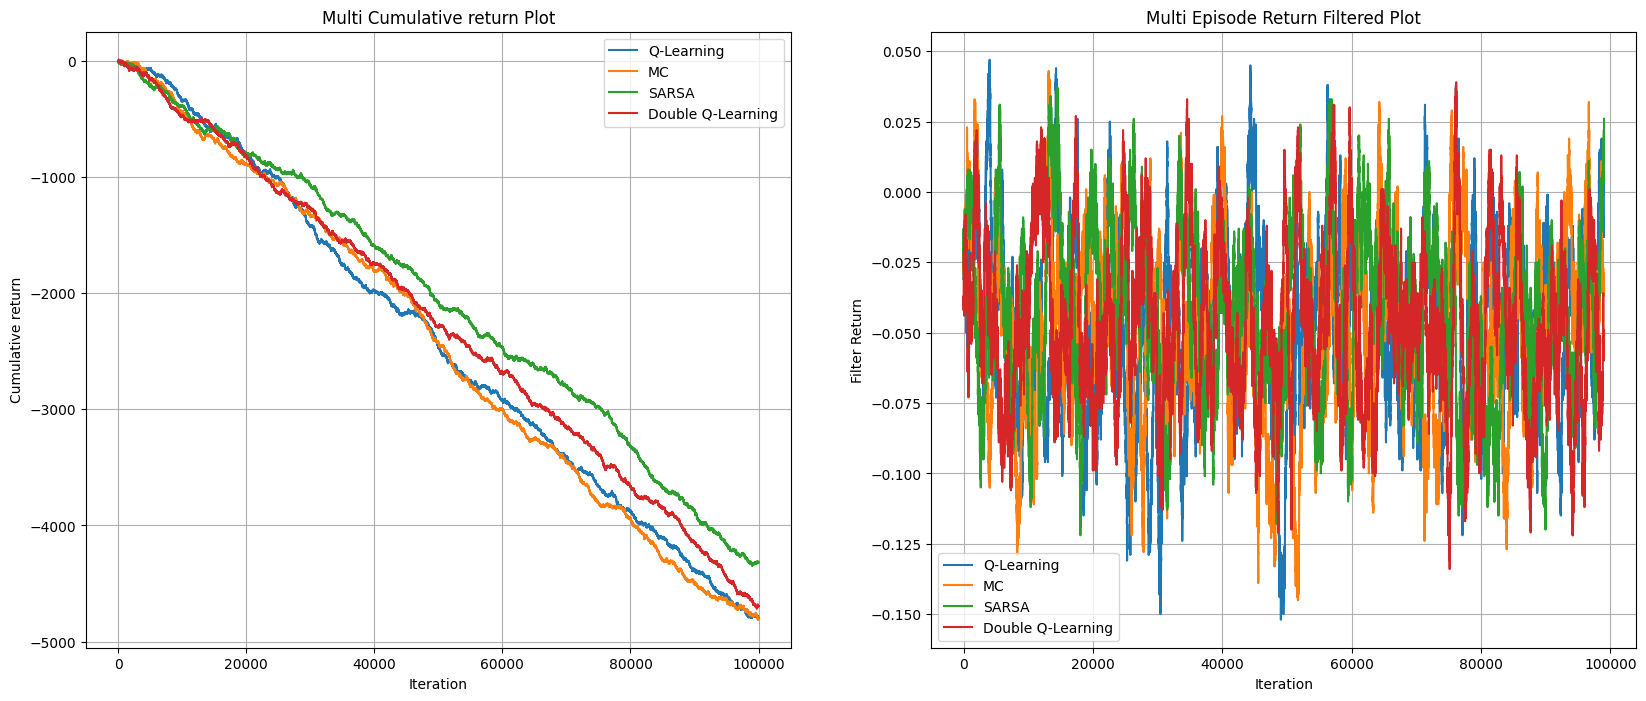

In [95]:
reward_compare_plot(Testing_Culmulative_Return_ls, Testing_reward_moving_average_ls)